# Data Source
The dataset is acquired from Kaggle competition "COVID-19 Open Research Dataset Challenge (CORD-19)"

Link to the dataset: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

# Data Description
This dataset was created by the Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for Security and Emerging Technology, Microsoft Research, IBM, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy. This is a periodically updated dataset and as of now it is of 25.35 GB.

In [ ]:
## Import all required libraries
import numpy as np 
import pandas as pd 
import json
import os
from tqdm import tqdm,tqdm_notebook
import gc

# Fetch the Dataset from Kaggle

In [ ]:
# Fetching all the json files from Kaggle which contains research papers

# this finds our json files
path_to_json = '/kaggle/input/CORD-19-research-challenge/document_parses/pdf_json'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files

In [ ]:
len(json_files)

# Exploratory Data Analysis (EDA)

In [ ]:
# here I define my pandas Dataframe with the columns I want to get from the json
# jsons_data = pd.DataFrame(columns=['country', 'city', 'long/lat'])
jsons_data = pd.DataFrame(columns=['paper_id', 'abstract', 'body_text'])

id2abstract = []
# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files[:1000]):     # Using 1000 files only to reduce memory load and resources
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)

        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        paper_id = json_text['paper_id']
#         abstract = json_text['abstract'][0]['text']
        abstract=''
        for entry in json_text['abstract']:
                abstract += entry['text']
        id2abstract.append({paper_id:abstract})
                #abstract.append(entry['text'])
        body_text=""
        for entry in json_text['body_text']:
                body_text += entry['text']
                #body_text.append(entry['text'])
                
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data.loc[index] = [paper_id, abstract, body_text]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data)

In [ ]:
# Display the dataframe
jsons_data

In [ ]:
df = jsons_data

In [ ]:
# Describe the New processed Dataframe
df.describe()

In [ ]:
# # Converting the columns in list to string for easy processing of the columns while tokenising
# df['abstract'] = [' '.join(map(str, l)) for l in df['abstract']]
# df['body_text'] = [' '.join(map(str, l)) for l in df['body_text']]
# df.head()

# Data Preprocessing

## Word count

In [ ]:
# Count of all tokens in the columns and unique words in the columns
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df['body_word_count'] = df['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df['body_unique_words']=df['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df.head()

## Check NULL Values

### Reasoning for Checking for NULL values
We have checked for NULL values, we need to remove all the NULL values before we train the model. This is because, NULL values don't have any values and they may cause a problem when the model is predicting.

In [ ]:
# Check if NULL values are present in the dataset along with count of the NULL values
for col in df.columns:
    print(col, df[col].isnull().sum())

### Delete all rows for whose word count is 0

In [ ]:
# Thanks to https://www.codegrepper.com/code-examples/delphi/delete+rows+pandas+if+column+contains
# Thanks to https://stackoverflow.com/questions/49841989/python-drop-value-0-row-in-specific-columns

# Let’s delete all rows for whose word count is 0
df.drop(df.index[df['abstract_word_count'] == 0], inplace = True)
df.drop(df.index[df['body_word_count'] == 0], inplace = True)
# df = df.loc[~((df['abstract_word_count'] == 0) | (df['body_word_count'] == 0))]
df

## Lower Case

### Reasoning for Converting to Lower case

We are converting all the strings to lower case because, when training the model, it should not treat the capitalized words and non-capitalized words differently which may decrease the accuracy of the model later. To treat them equal, we are converting all of the string to Lower case.

In [ ]:
# Converting strings to Lower case
df["abstract"] = df["abstract"].str.lower() 
df["body_text"] = df["body_text"].str.lower() 
df.head(10)

## Stop Words

### Reasoning for removing Stopwords

Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

The common language specific stop word list generally DOES NOT cover such domain specific terms. Similarly, for tweets, terms like “#” “RT”, “@username” can be potentially regarded as stop words.

In our dataset, we are dealing with research papers. So the words like 'doi', 'copyright','org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'fig', etc. are used more frequently which will not be considered as common stopwords in English. Hence we're customizing the stopwords list.

In [ ]:
### load stopwords 
import nltk
nltk.download('stopwords')

In [ ]:
# Thanks to https://medium.com/analytics-vidhya/text-summarization-on-covid-19-research-data-a5ab28695e11

stopwords_custom = nltk.corpus.stopwords.words('english')
customize_stop_words = ['common','review','describes','abstract','retrospective','chart','patients','study','may',
                        'associated','results','including','high''found','one','well','among','Abstract','provide',
                        'objective','objective:','background','range','features','participates','doi', 'preprint', 
                        'copyright', 'org', 'https', 'et ','et' 'al', 'author', 'figure', 'table', 'rights', 'reserved', 
                        'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 
                        'Elsevier', 'PMC', 'CZI']
### append custom stopwords to default stopwords from NLTK
for i in customize_stop_words:
    stopwords_custom.append(i)

In [ ]:
df['abstract'] = df['abstract'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
df['body_text'] = df['body_text'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
df

## Contraction Words

### Reasoning for Replacing Contraction English words

For example,Who're you --> Who are you; Both sentences give the same meaning. In order to make the model understand that both are same and it should not treat them as seperate, we are replacing the contracted words.

In [ ]:
# Installing the Contractions Package
!pip install contractions

In [ ]:
# Using contractions library for replacing the contracted words in English 
import contractions
df['abstract'] = df['abstract'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
df['body_text'] = df['body_text'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
df.head()

## Remove punctuation marks

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer_pattern = RegexpTokenizer('\w+')
df['abstract'] = df['abstract'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
df['body_text'] = df['body_text'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
df

In [ ]:
df = df.reset_index(drop=True)
df

# Data Visualization

## Word Cloud

Word cloud is a technique for visualising frequent words in a text where the size of the words represents their frequency.

In [ ]:
# Thanks to https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
abstract_text = str(df.abstract)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(abstract_text)
# Plot
plot_cloud(wordcloud)

In [ ]:
text = str(df.body_text)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(text)
# Plot
plot_cloud(wordcloud)

In [ ]:
# from transformers import pipeline
# summarizer = pipeline("summarization")

In [ ]:
# # Summarization
# for i, text in enumerate(df_test['abstract']):
#     summary_text = summarizer(df_test['abstract'].iloc[i], max_length=1000, min_length=30)
#     print(summary_text)
#     print()
#     df_test['abstract'].iloc[i] = summary_text[0]['summary_text']
#     #print(summary_text[0]['summary_text'])

# BERT QA Model & Text summarization

### Reasoning for the models chosen

#### Why BERT?

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based method of learning language representations. It is a bidirectional transformer pre-trained model developed using a combination of two tasks namely: masked language modeling objective and next sentence prediction on a large corpus. Since we are dealing with large quantity of text corpus (COVID related articles) and BERT also had many pre-trained QA models (pipelines) which are trained on huge quantity of data. There are also models like "deepset/covid_bert_base" (trained on COVID data), "dmis-lab/biobert-base-cased-v1.1" (trained on medicine data) which supports QA modeling along with the sufficient data. So we opted out for BERT.

#### Why bert-large-cased-whole-word-masking-finetuned-squad?

The models that QA pipeline use is the model that have been fine-tuned on a question answering task. (Source: huggingface). Since we need to build QA model we opted for this model. It will be somewhat easy to fine tune a pre trained model according to our requirements instead of writing all the deep learning codes and training that model on huge and quality data to perform well. So we used pre-trained QA model and fine tuned according to our requirements of the dataset.

#### Why Summarization?

Summarization is the process of shortening a set of data computationally, to create a subset (a summary) that represents the most important or relevant information within the original content. Summarization has been used many practical applications — summarizing articles, summarizing multiple documents on the same topic, summarizing video content to generate highlights in sports etc. Summarization in text, specifically, can be extremely useful as it saves the users having to read long articles, blogs or other pieces of text. 

#### Why transformers Summarization pipeline model (transformers.QuestionAnsweringPipeline)?
For the process of summarization we used the pre tr****ained summarizer from transformers library. We used this model because its implementation is very simple and easy to understand and also it is from transformers library where BERT also belongs to. So we thought they could complement each other to tune the model and chode it.

In [ ]:
# BERT QA model
from transformers import pipeline
nlp = pipeline('question-answering',model = 'bert-large-cased-whole-word-masking-finetuned-squad')

In [ ]:
query_sample = "How to prevent Corona ?"
relevant_sentence = df['abstract'].values
nlp(question = query_sample, context = relevant_sentence)

## BLEU Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu   # Library to compare two sentences and calculate score using BLEU
from nltk.tokenize import word_tokenize  # NLTK library to tokenize the expected and acquired results

def compare_bleu(result, expected):    
    token_res = word_tokenize(result)    # Tokenize the acquired results
    token_exp = word_tokenize(expected)  # Tokenize the expected results
    score = sentence_bleu(token_res, token_exp)   # Compare two sentences and calculate score
    print("The BLEU score of accuracy is: ", score)

In [ ]:
# Define the expected answer to a new variable
expected_Summary_text_1 = "Coronavirus disease 2019 (COVID-19) is a respiratory illness that can spread from person to person. CDC has information on COVID-19 symptoms and caring for yourself and others. COVID-19 is a new disease, caused by a novel (or new) coronavirus that has not previously been seen in humans. A novel coronavirus is a new coronavirus that has not been previously identified. The virus causing coronavirus disease 2019 (COVID-19), is not the same as the coronaviruses that commonly circulate among humans and cause mild illness, like the common cold."
expected_Summary_text_2 = "The incubation period for COVID-19 is thought to extend to 14 days, with a median time of 4-5 days from exposure to symptoms onset. One study reported that 97.5% of persons with COVID-19 who develop symptoms will do so within 11.5 days of SARS-CoV-2 infection."

In [ ]:
compare_bleu(Summary_text_4, expected_Summary_text_1)

In [ ]:
compare_bleu(Summary_text_5, expected_Summary_text_2)

## ROUGE Score

In [ ]:
# Thanks to https://pypi.org/project/rouge-score/
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(Summary_text_4, expected_Summary_text_1)
scores

In [ ]:
scores = scorer.score(Summary_text_5, expected_Summary_text_2)
scores

# Method - 3 BERT QA & BERT Pipeline Summarization

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")

In [ ]:
def Summary_Model(pd,count,model):
    summary_text = ''
    total_abstract = ''
    for i in range(len(pd[:count])):
        abss, ans = pd.loc[i,['abstract_by_ans','Answer']].values
        total_abstract += (abss + ".")
    ARTICLE_TO_SUMMARIZE = total_abstract
    print(ARTICLE_TO_SUMMARIZE)
    summary_text = summarizer(ARTICLE_TO_SUMMARIZE)
    return summary_text

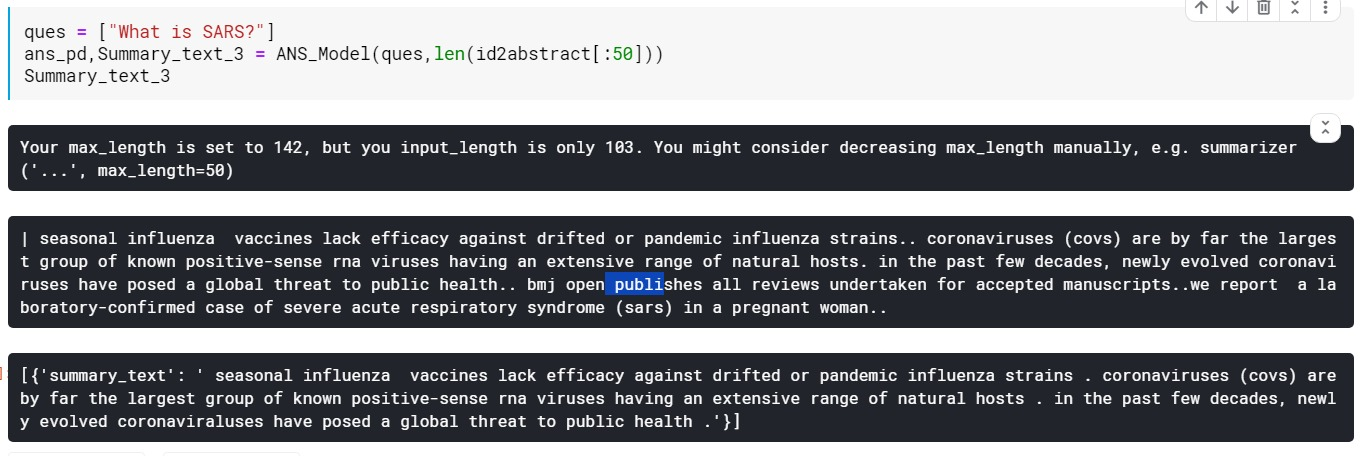

Below image represents the BLEU and ROUGE score for this model

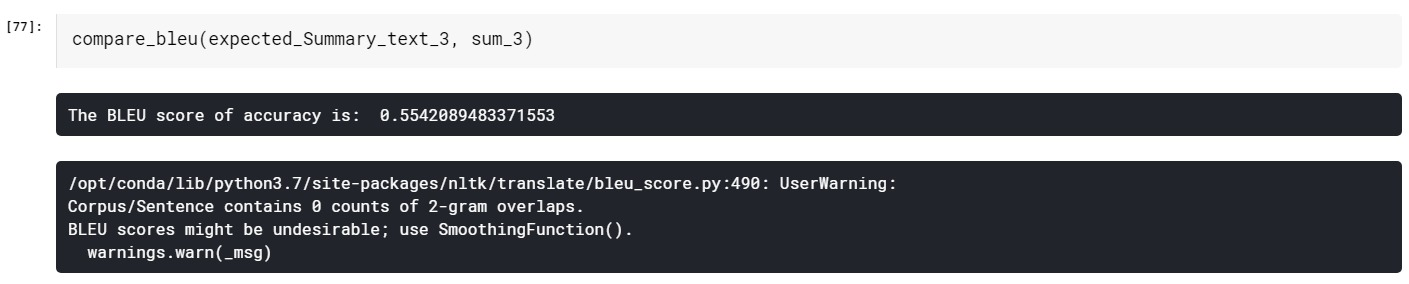

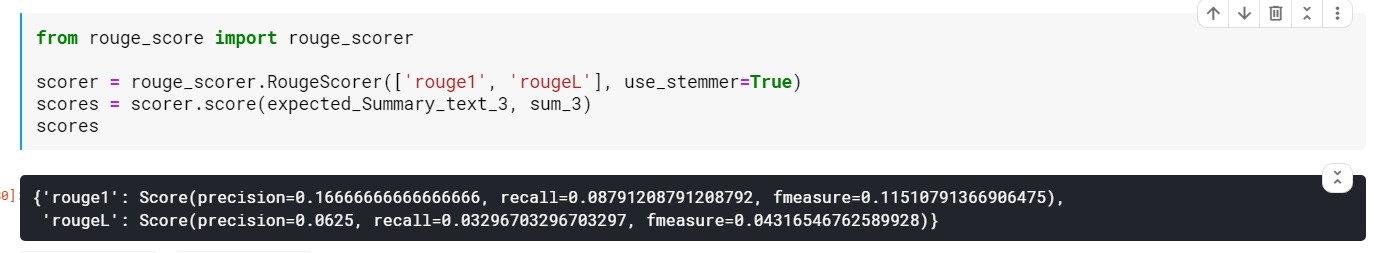

# References

- BERTScore: https://github.com/Tiiiger/bert_score
- BLEU Score: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=Crash%2DCourse%20Now-,Bilingual%20Evaluation%20Understudy%20Score,in%20a%20score%20of%200.0.
- QA Using bert pretrained model by SQuAD: https://github.com/google-research/bert
- All tasks list: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks
- BERT model: https://www.kaggle.com/dirktheeng/anserini-bert-squad-for-semantic-corpus-search
- Dataset: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge